In [1]:
import argparse
import json
import os
import time
import ast
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import IntendedReceiverDataset
from src.my_model import DualTransformer
from src.utils import calc_class_acc, get_params_str, num_trainable_params

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.visualization import plot_action

In [3]:
params = {
    "model": 'transformer',
    "batch_size": 1,
    "n_features": 6,
    "n_classes": 11,
    "context_dim": 32,
    "trans_dim": 256,
    "add_info" : True
    
}

default_device = "cuda:0"
model = nn.DataParallel(DualTransformer(params).to(default_device))
save_path = "saved/{:03d}".format(50)
state_dict = torch.load("{}/model/{}_state_dict_best.pt".format(save_path, params['model']))
model.module.load_state_dict(state_dict)
model = model.eval()

In [4]:
lst = []
for keys in state_dict.keys():
    lst.append(keys.split(".")[0])


from collections import Counter

Counter(lst)

Counter({'player_temporal_encoder': 24,
         'player_spatial_encoder': 24,
         'dist_temporal_encoder': 24,
         'dist_spatial_encoder': 24,
         'angle_temporal_encoder': 24,
         'angle_spatial_encoder': 24,
         'player_input_fc': 2,
         'dist_input_fc': 2,
         'angle_input_fc': 2,
         'output_fc': 2,
         'time_pos_encoder': 1,
         'player_pos_encoder': 1})

In [5]:
unsuccess_include = True

#실패한 패스를 학습할 때 사용하지 않은 경우
if not unsuccess_include:
    dataset = pd.read_csv('../data/EPV-data/labeling-all-match.csv')

    dataset = dataset[(dataset["eventName"] == "Pass") & (dataset["accurate"] == 0) & (dataset['start_frame'] < dataset['end_frame'])]

    print(dataset.shape)
    dataset = dataset[dataset['no pass'].isna()]
    print(dataset.shape)
    dataset = dataset[dataset['True Intended-receiver'].notna()]
    print(dataset.shape)

    dataset = dataset.drop(columns=['to'])
    dataset = dataset.rename(columns={'True Intended-receiver':'to'})
else:
    #실패한 패스 일부도 학습할 때 사용하는 경우
    dataset = pd.read_csv(f'./{save_path}/unsuccess_test_dataset.csv')    
    print(dataset.shape)

dataset.head(8)

(184, 26)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass
0,Away,BALL LOST,INTERCEPTION,2,122067,4882.68,122144,4885.76,B15,47.52000,...,2,Pass,"{'A02': {'teammate': False, 'actor': False, 'b...",0.0,0,"{'dist': {'ID': 'B27', 'end_x': 59.71428, 'end...",1,1477,B28,NaN
1,Away,BALL LOST,INTERCEPTION,1,67159,2686.36,67214,2688.56,B20,63.72000,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B19', 'end_x': 44.99928, 'end...",1,841,B17,NaN
2,Home,BALL LOST,INTERCEPTION,1,54841,2193.64,54868,2194.72,A08,46.44000,...,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 77.11632, 'end...",2,2575,A09,NaN
3,Away,BALL LOST,INTERCEPTION,2,82620,3304.80,82678,3307.12,A01,36.95220,...,2,Pass,"{'A01': {'teammate': True, 'actor': True, 'bal...",0.0,0,"{'dist': {'ID': 'A07', 'end_x': 52.82496, 'end...",3,5784,A07,NaN
4,Home,BALL LOST,INTERCEPTION,1,31295,1251.80,31335,1253.40,A09,28.08000,...,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A01', 'end_x': 75.68639999999...",2,2235,A01,NaN
5,Home,BALL LOST,INTERCEPTION,1,43270,1730.80,43324,1732.96,A02,48.60000,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 74.34072, 'end...",1,533,A09,NaN
6,Home,BALL LOST,INTERCEPTION,1,42141,1685.64,42151,1686.04,B18,105.63372,...,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B27', 'end_x': 98.35884, 'end...",3,4778,B27,NaN
7,Home,BALL OUT,DEEP BALL,1,49696,1987.84,49824,1992.96,B23,60.57288,...,1,Pass,"{'B28': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B27', 'end_x': 75.79224, 'end...",3,4944,B26,NaN


In [6]:
nw = len(model.device_ids) * 4
test_dataset = IntendedReceiverDataset(dataset)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=nw, pin_memory=True)
test_loader

158


In [7]:
losses = []

target_labels = []
predicted_labels = []

for batch_idx, data in tqdm(enumerate(test_loader)):
    passer_input = data[0].to(default_device)
    teammate_input = data[1].to(default_device)
    opponent_input = data[2].to(default_device)
    ball_input = data[3].to(default_device)

    team_poss_input = data[4].to(default_device)
    event_player_input = data[5].to(default_device)

    input = [
        passer_input,
        teammate_input,
        opponent_input,
        ball_input,
        team_poss_input,
        event_player_input,
    ]
    
    passer_mask_list = data[6].to(default_device)
    target = data[7].to(default_device)

    with torch.no_grad():
        out = model(*input)
        
    batch_size, _ = out.shape
    # 모든 값이 0인 mask 생성
    mask = torch.zeros_like(out)
    batch_indices = np.arange(batch_size)
    mask[batch_indices, passer_mask_list] = -np.inf
    out += mask 

    loss = nn.CrossEntropyLoss()(out, target)

    out = torch.softmax(out,dim=1)
    pred = torch.argmax(out).item()

    losses.append(loss.item())
    target_labels.append(target.item())
    predicted_labels.append(pred)  

best_accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()

print("loss : ", np.mean(losses))
print("accuracy : ", best_accuracy)

158it [00:02, 57.73it/s]

loss :  0.9602339418479344
accuracy :  0.620253164556962


158it [00:02, 68.41it/s]0:00<?, ?it/s]
158it [00:02, 67.38it/s]0:02<00:22,  2.47s/it]
158it [00:02, 61.84it/s]0:04<00:19,  2.48s/it]
158it [00:02, 60.35it/s]0:07<00:18,  2.59s/it]
158it [00:02, 70.35it/s]0:10<00:15,  2.66s/it]
158it [00:02, 67.51it/s]0:12<00:12,  2.57s/it]
158it [00:02, 64.83it/s]0:15<00:10,  2.55s/it]
158it [00:02, 58.65it/s]0:17<00:07,  2.57s/it]
158it [00:02, 59.51it/s]0:20<00:05,  2.66s/it]
158it [00:02, 59.93it/s]0:23<00:02,  2.71s/it]
100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


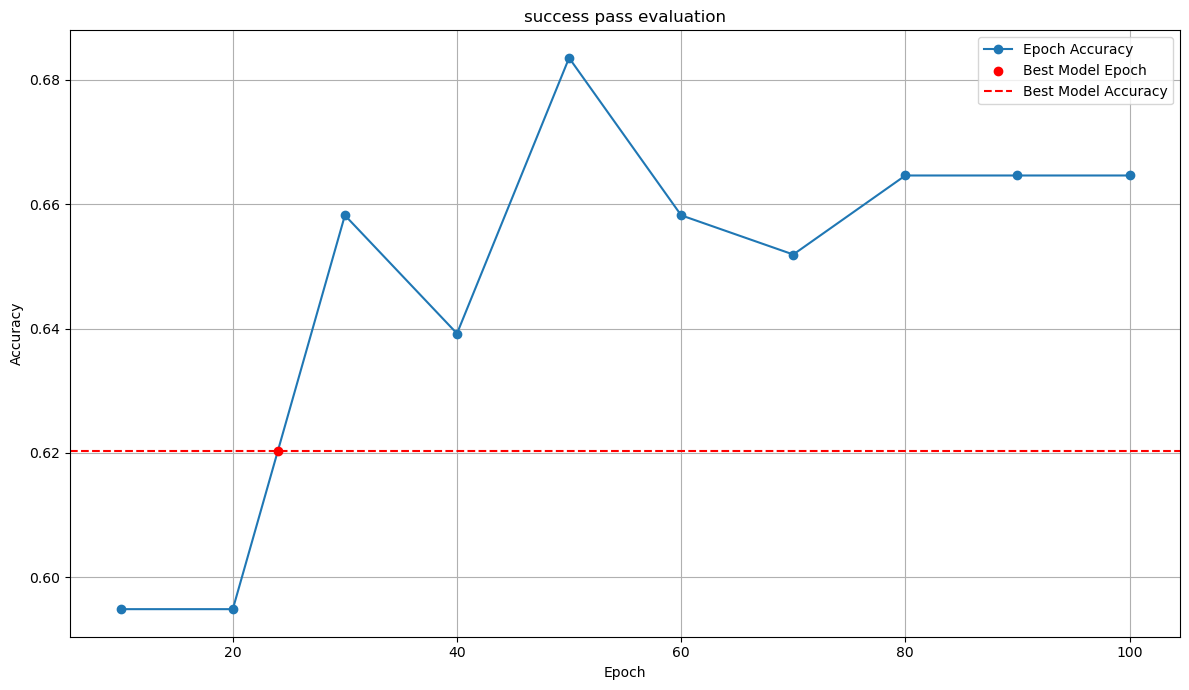

In [8]:
accuracy_lst = []
def test_model(pt, model, test_loader, default_device):
    losses = []

    target_labels = []
    predicted_labels = []

    for _, data in tqdm(enumerate(test_loader)):
        passer_input = data[0].to(default_device)
        teammate_input = data[1].to(default_device)
        opponent_input = data[2].to(default_device)
        ball_input = data[3].to(default_device)

        team_poss_input = data[4].to(default_device)
        event_player_input = data[5].to(default_device)

        input = [
            passer_input,
            teammate_input,
            opponent_input,
            ball_input,
            team_poss_input,
            event_player_input,
        ]

        passer_mask_list = data[6].to(default_device)
        target = data[7].to(default_device)

        with torch.no_grad():
            out = model(*input)
            
        batch_size, _ = out.shape
        # 모든 값이 0인 mask 생성
        mask = torch.zeros_like(out)
        batch_indices = np.arange(batch_size)
        mask[batch_indices, passer_mask_list] = -np.inf
        out += mask 

        loss = nn.CrossEntropyLoss()(out, target)

        out = torch.softmax(out,dim=1)
        pred = torch.argmax(out).item()

        losses.append(loss)
        target_labels.append(target.item())
        predicted_labels.append(pred)  

    accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()
    accuracy_lst.append(accuracy.round(4))

max_pt = 100
for pt in tqdm(range(10, max_pt+1, 10)):
    state_dict = torch.load("{}/model/{}_state_dict_{}.pt".format(save_path, params['model'], pt))
    model.module.load_state_dict(state_dict)
    model = model.eval()

    test_model(pt, model, test_loader, default_device)

plt.figure(figsize=(12, 7))

x_coords = list(range(10, max_pt+1, 10))
x_ticks = [str(epoch) if epoch % 50 == 0 or epoch == max_pt else '' for epoch in range(10, max_pt+1, 10)]

plt.plot(x_coords, accuracy_lst, label='Epoch Accuracy', marker='o', zorder=3)

plt.scatter(24, best_accuracy, color='red', label='Best Model Epoch', zorder=5)
plt.axhline(y=best_accuracy, color='red', linestyle='--', label='Best Model Accuracy', zorder=2)
# Best Model 점 표시

plt.title('success pass evaluation')
plt.xlabel('Epoch')
#plt.xticks(x_coords, x_ticks, rotation=45)  # 'best' 라벨 제외
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()